<a href="https://colab.research.google.com/github/minghsu0107/ML/blob/master/machine-learning/tuning_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Optimization

The one-sentence summary of Bayesian hyperparameter optimization is: build a probability model of the objective function and use it to select the most promising hyperparameters to evaluate in the true objective function.

1. Build a surrogate probability model of the objective function
2. Find the hyperparameters that perform best on the surrogate
3. Apply these hyperparameters to the true objective function
4. Update the surrogate model incorporating the new results
Repeat steps 2–4 until max iterations or time is reached

## gaussian process-based optimization

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

boston = load_boston()
X, y = boston.data, boston.target
n_features = X.shape[1]

# gradient boosted trees tend to do well on problems like this
reg = GradientBoostingRegressor(n_estimators=50, random_state=0)

In [0]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args


# The list of hyper-parameters we want to optimize. For each one we define the bounds,
# the corresponding scikit-learn parameter name, as well as how to sample values
# from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(1, 5, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

# If you have a search-space where all dimensions have names, 
# then you can use skopt.utils.use_named_args as a decorator on your objective function, 
# in order to call it directly with the named arguments.
@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

In [0]:
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

"Best score=%.4f" % res_gp.fun

'Best score=2.9453'

In [0]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4]))

Best parameters:
- max_depth=5
- learning_rate=0.106481
- max_features=11
- min_samples_split=100
- min_samples_leaf=1


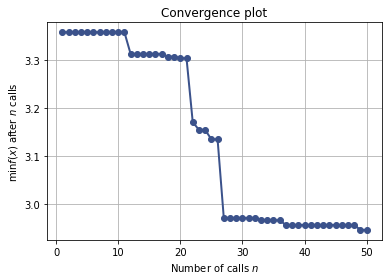

In [0]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

## More gaussian process

In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter(default=50).

In [0]:
!pip3 install scikit-learn==0.20.3

     |████████████████████████████████| 5.4MB 6.6MB/s 
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3


In [0]:
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X, y = load_digits(10, True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=.25, random_state=0)


# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    SVC(),
    search_spaces = {
        'C': (1e-6, 1e+6, 'log-uniform'),  
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf']  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
opt.best_params_

val. score: 0.991833704528582
test score: 0.9933333333333333


{'C': 39.677110302416466,
 'degree': 3,
 'gamma': 0.0006991037058299821,
 'kernel': 'rbf'}

In [0]:
clf = SVC()
clf.set_params(**opt.best_params_)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test))

0.9755555555555555


In [0]:
from skopt import BayesSearchCV

from sklearn.datasets import load_iris
from sklearn.svm import SVC

X, y = load_iris(True)

searchcv = BayesSearchCV(
    SVC(),
    search_spaces={'C': (0.01, 100.0, 'log-uniform')},
    n_iter=10,
    verbose=0,
    scoring="precision_macro"
)

def on_step(optim_result):
    score = searchcv.best_score_
    print("best score: %s" % score)
    if score >= 0.98:
        print('Interrupting!')
        return True

searchcv.fit(X, y, callback=on_step)
print("val. score: %s" % searchcv.best_score_)
searchcv.best_params_

best score: 0.9817738791423002
Interrupting!
val. score: 0.9817738791423002


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change fro

{'C': 5.393251930490651}

In [0]:
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import SequentialFeatureSelector
import warnings

warnings.simplefilter('ignore')
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, :], iris.target


clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

# Creating a feature-selection-classifier pipeline

sfs1 = SequentialFeatureSelector(clf1, 
                                 k_features=4,
                                 forward=True, 
                                 floating=False, 
                                 scoring='accuracy',
                                 verbose=0,
                                 cv=0)

clf1_pipe = Pipeline([('sfs', sfs1),
                      ('logreg', clf1)])

eclf = EnsembleVoteClassifier(clfs=[clf1_pipe, clf2, clf3], 
                              voting='soft')


params = {'pipeline__sfs__k_features': [1, 2, 3],
          'pipeline__logreg__C': (1.0, 100.0, 'log-uniform'),
          'randomforestclassifier__n_estimators': (20, 200)}
# if scoring = None, use the estimator's score method(same as GridSearchCV)
searchcv = BayesSearchCV(
    eclf,
    search_spaces=params,
    n_iter=40,
    verbose=0,
    scoring="precision_macro"
)
searchcv.fit(X, y)

BayesSearchCV(cv=None, error_score='raise',
       estimator=EnsembleVoteClassifier(clfs=[Pipeline(memory=None,
     steps=[('sfs', SequentialFeatureSelector(clone_estimator=True, cv=0,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
...(priors=None, var_smoothing=1e-09)],
            refit=True, verbose=0, voting='soft', weights=None),
       fit_params=None, iid=True, n_iter=40, n_jobs=1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=False, scoring='precision_macro',
       search_spaces={'pipeline__sfs__k_features': [1, 2, 3], 'pipeline__logreg__C': (1.0, 100.0, 'log-uniform'), 'randomforestclassifier__n_estimators': (20, 200)},
       verbose=0)

In [0]:
print("val. score: %s" % searchcv.best_score_)
searchcv.best_params_

val. score: 0.9606481481481481


{'pipeline__logreg__C': 2.750946971987132,
 'pipeline__sfs__k_features': 3,
 'randomforestclassifier__n_estimators': 79}

## Using bayesian-optimization package

### Simple example

In [0]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import warnings
warnings.simplefilter('ignore')

x, y = make_classification(n_samples=1000, n_features=10, n_classes=2)

In [0]:
import numpy as np
rf = RandomForestClassifier()
print(np.mean(cross_val_score(rf, x, y, cv=20, scoring='roc_auc')))

0.9876508974358973


In [0]:
def rf_cv(n_estimators, min_samples_split, max_features, max_depth):
    val = cross_val_score(
        RandomForestClassifier(n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=min(max_features, 0.999), # float
            max_depth=int(max_depth),
            random_state=2
        ),
        x, y, scoring='roc_auc', cv=5).mean()
    return val

In [0]:
rf_bo = BayesianOptimization(
        rf_cv,
        {'n_estimators': (10, 250),
        'min_samples_split': (2, 25),
        'max_features': (0.1, 0.999),
        'max_depth': (5, 15)})
# defualt: choose 5 samples initially, then iterate for 25 times(30 times in total)
rf_bo.maximize()

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  0.983    |  8.742    |  0.9283   |  18.72    |  222.9    |
|  2        |  0.9825   |  10.66    |  0.9646   |  9.939    |  87.8     |
|  3        |  0.9858   |  11.96    |  0.6632   |  19.66    |  230.1    |
|  4        |  0.9858   |  8.466    |  0.5774   |  18.45    |  181.3    |
|  5        |  0.9841   |  12.38    |  0.4495   |  20.24    |  63.53    |
|  6        |  0.9852   |  14.0     |  0.2821   |  2.251    |  250.0    |
|  7        |  0.9844   |  5.374    |  0.9904   |  24.85    |  249.5    |
|  8        |  0.9824   |  14.04    |  0.9248   |  2.076    |  249.7    |
|  9        |  0.9816   |  5.506    |  0.6935   |  24.42    |  10.43    |
|  10       |  0.9793   |  6.036    |  0.1537   |  24.51    |  249.9    |
|  11       |  0.9699   |  14.37    |  0.997    |  2.003    |  11.2     |
|  12       |  0.9829   |  15.0     | 

In [0]:
rf_bo.max

{'params': {'max_depth': 8.46618268560162,
  'max_features': 0.5774248505640364,
  'min_samples_split': 18.447776971497508,
  'n_estimators': 181.34369329062656},
 'target': 0.9858162196219622}

### Optimize lightGBM

In [0]:
from sklearn.datasets import load_boston
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [0]:
data = load_boston()
X = data.data
Y = data.target
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=2019)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

if we don't do the hyperparameter tuning

0.5842211473283357
2.488337768978677
0.786481538974334


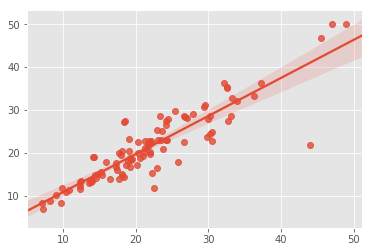

In [0]:
regressor = lgb.LGBMRegressor(n_estimators=80)
regressor.fit(X_train,Y_train)

print(cross_val_score(regressor, X_test, Y_test, cv=5, scoring='r2').mean())
print(metrics.mean_absolute_error(regressor.predict(X_test), Y_test))
print(metrics.r2_score(regressor.predict(X_test),Y_test))
sns.regplot(regressor.predict(X_test), Y_test)

Start tuning

In [0]:
def LGB_CV(
          max_depth,
          num_leaves,
          min_data_in_leaf,
          feature_fraction,
          bagging_fraction,
          lambda_l1
         ):
    
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(X_train.shape[0])

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, Y_train)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(X_train[trn_idx],
                               label=Y_train[trn_idx],
                               )
        val_data = lgb.Dataset(X_train[val_idx],
                               label=Y_train[val_idx],
                               )
    
        param = {
            'num_leaves': int(num_leaves),
            'min_data_in_leaf': int(min_data_in_leaf), 
            'objective':'regression',
            'max_depth': int(max_depth),
            'learning_rate': 0.01,
            "boosting": "gbdt",
            "feature_fraction": feature_fraction,
            "bagging_freq": 1,
            "bagging_fraction": bagging_fraction ,
            "bagging_seed": 11,
            "metric": 'rmse',
            "lambda_l1": lambda_l1,
            "verbosity": -1
        }
    
        clf = lgb.train(param,
                        trn_data,
                        5000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds = 200)
        
        oof[val_idx] = clf.predict(X_train[val_idx],
                                   num_iteration=clf.best_iteration)
        
        del clf, trn_idx, val_idx
        
    return metrics.r2_score(oof, Y_train)

In [0]:
LGB_BO = BayesianOptimization(LGB_CV, {
    'max_depth': (4, 20),
    'num_leaves': (5, 130),
    'min_data_in_leaf': (5, 30),
    'feature_fraction': (0.7, 1.0),
    'bagging_fraction': (0.7, 1.0),
    'lambda_l1': (0, 6)
    })
LGB_BO.maximize(init_points=2,n_iter=3)

|   iter    |  target   | baggin... | featur... | lambda_l1 | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------
fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1.89199	valid_1's rmse: 3.54411
Early stopping, best iteration is:
[358]	training's rmse: 2.22523	valid_1's rmse: 3.51324
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1.84809	valid_1's rmse: 3.26396
[1000]	training's rmse: 1.23477	valid_1's rmse: 3.08713
[1500]	training's rmse: 0.96906	valid_1's rmse: 3.04648
[2000]	training's rmse: 0.833759	valid_1's rmse: 3.04132
Early stopping, best iteration is:
[1837]	training's rmse: 0.868068	valid_1's rmse: 3.03965
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 1.87329	valid_1's rmse: 3.03392
[1000]	training's rmse: 1.22766	valid_1's rmse: 2.92991
[1500]	training'

In [0]:
LGB_BO.max

{'params': {'bagging_fraction': 0.8197886672360276,
  'feature_fraction': 0.7108687601949996,
  'lambda_l1': 0.6371127266235574,
  'max_depth': 19.75375283569926,
  'min_data_in_leaf': 5.32540871062938,
  'num_leaves': 126.25771040286507},
 'target': 0.8436644618100338}

In [0]:
params = {
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'max_depth': 20,
    'min_data_in_leaf': 5,
    'bagging_fraction': 0.8197886672360276,
    'feature_fraction': 0.7108687601949996,
    'lambda_l1': 0.6371127266235574,
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 126
}

lgb_train = lgb.Dataset(X_train, Y_train)
cv_results = lgb.cv(
    params, lgb_train, num_boost_round=10000, nfold=5, stratified=False, shuffle=True,
    early_stopping_rounds=200, verbose_eval=False, show_stdv=True)
import pandas as pd
df = pd.DataFrame(cv_results)

In [0]:
print("n_estimators: %d" % df.shape[0])
params['n_estimators'] = df.shape[0]
params['reg_alpha'] = params['lambda_l1']
params['subsample'] = params['bagging_fraction']
params['colsample_bytree'] = params['feature_fraction']
params['min_child_samples'] = params['min_data_in_leaf']

del params['lambda_l1']
del params['bagging_fraction']
del params['feature_fraction']
del params['min_data_in_leaf']

clf = lgb.LGBMRegressor()
clf.set_params(**params)
print(cross_val_score(clf, X_train, Y_train, cv=5, scoring='r2').mean())
print(cross_val_score(clf, X_test, Y_test, cv=5, scoring='r2'))

clf.fit(X_train, Y_train)
print(metrics.mean_absolute_error(clf.predict(X_test), Y_test))
print(metrics.r2_score(clf.predict(X_test), Y_test))

n_estimators: 2298
0.8804234881485904
[0.70824799 0.75458857 0.4814469  0.54968513 0.78070485]
2.3451064680565437
0.7922320217457438


Another way

In [0]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(X_train.shape[0])
predictions = np.zeros(X_test.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, Y_train)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(X_train[trn_idx],
                           label=Y_train[trn_idx],
                           )
    val_data = lgb.Dataset(X_train[val_idx],
                           label=Y_train[val_idx],
                           )

    param = {
        'num_leaves': 43,
        'min_data_in_leaf': 13, 
        'objective':'regression',
        'max_depth': 9,
        'learning_rate': 0.01,
        "boosting": "gbdt",
        "feature_fraction": 0.7033424815486718,
        "bagging_freq": 1,
        "bagging_fraction": 0.7782865625857565,
        "bagging_seed": 11,
        "metric": 'rmse',
        "lambda_l1": 4.606948240110736,
        "verbosity": -1
    }

    clf = lgb.train(param,
                    trn_data,
                    5000,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)

    oof[val_idx] = clf.predict(X_train[val_idx],
                               num_iteration=clf.best_iteration)
#     del clf, trn_idx, val_idx
    predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits
#     del clf, trn_idx, val_idx

fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 2.19689	valid_1's rmse: 3.6012
Early stopping, best iteration is:
[400]	training's rmse: 2.40339	valid_1's rmse: 3.57248
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 2.16088	valid_1's rmse: 3.29423
[1000]	training's rmse: 1.51569	valid_1's rmse: 3.08237
[1500]	training's rmse: 1.20131	valid_1's rmse: 3.03968
Early stopping, best iteration is:
[1497]	training's rmse: 1.20283	valid_1's rmse: 3.03917
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 2.18357	valid_1's rmse: 3.10094
[1000]	training's rmse: 1.55089	valid_1's rmse: 2.99352
Early stopping, best iteration is:
[1057]	training's rmse: 1.50767	valid_1's rmse: 2.98875
fold n°3
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 2.11155	valid_1's rmse: 3.277
[1000]	training's rmse: 1.4893	valid_1's rmse: 3.16153


In [0]:
from sklearn import metrics
print(metrics.mean_absolute_error(predictions, Y_test))
print(metrics.r2_score(predictions, Y_test))

2.308559127312389
0.7994514995860382


## using Hyperopt

In [0]:
import csv
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
data = load_boston()
X = data.data
Y = data.target
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=50)

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

#儲存結果的file 
out_file = 'gbm_trials.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
# 寫入header的名稱
writer.writerow(['loss', 'params', 'iteration', 'estimators', 'train_time'])
of_connection.close()

In [0]:
from timeit import default_timer as timer
import lightgbm as lgb
from hyperopt import STATUS_OK

#建立評估次數
MAX_EVALS = 200
#建立kfold 意思是要將資料分成幾個group
#意思為分成10組 取1組當test set 剩下的就是train set
N_FOLDS = 10

train_set = lgb.Dataset(X_train,label = y_train)

def objective(params, n_folds = N_FOLDS):
    #會紀錄最後的運行紀錄
    global ITERATION
    ITERATION += 1
    subsample = params['boosting_type'].get('subsample', 1.0)
    params['boosting_type'] = params['boosting_type']['boosting_type']
    params['subsample'] = subsample
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        params[parameter_name] = int(params[parameter_name])
    #準備計算跑model的時間
    start = timer()
    #交叉驗證 early_stopping_rounds是指超過100次都沒有改善的話就會停止模型
    cv_results = lgb.cv(params, train_set, num_boost_round=10000, nfold=n_folds,
                        stratified=False, shuffle=True, metrics='rmse',
                        early_stopping_rounds=100, verbose_eval=False, show_stdv=True)
    
    #總運行時間
    run_time = timer() - start
    loss = np.min(cv_results['rmse-mean'])
    
    #estimators(樹的數量)
    n_estimators = int(np.argmin(cv_results['rmse-mean']) + 1)
    #將所獲的資料寫入csv裡
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, n_estimators, run_time])
    return {'loss': loss, 'params': params, 'iteration': ITERATION,
            'estimators': n_estimators, 
            'train_time': run_time, 'status': STATUS_OK}

會使用的hp的機率函數型態
choice:針對屬性資料(uniform)
quniform:針對非連續性資料(uniform)
uniform:針對連續性資料(uniform)
loguniform:針對連續性log資料(uniform)

In [0]:
from hyperopt import hp
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    #subsample代表為採樣數
    #因為'goss'並無區分是否含有採樣數 所以給予1(不採樣)
    'boosting_type': hp.choice('boosting_type', [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                                 #{'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                                 {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0)}

In [0]:
import csv
from hyperopt import tpe
tpe_algorithm = tpe.suggest

from hyperopt import Trials
# Keep track of results
bayes_trials = Trials()

In [0]:
from hyperopt import fmin

# Global variable
global  ITERATION
ITERATION = 0
#ITERATION可以讓我們看iteration的數量
# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest,
            max_evals = MAX_EVALS, trials = bayes_trials, rstate = np.random.RandomState(50))

100%|██████████| 180/180 [18:50<00:00,  4.31s/it, best loss: 3.4854498230702413]


不會像grid search不會了解資料的好壞和無意義的跑高loss的model

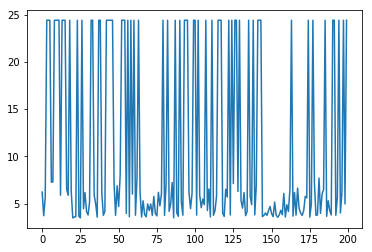

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

results1=pd.read_csv('gbm_trials.csv')
plt.plot(results1['loss'])

In [0]:
results = pd.read_csv('gbm_trials.csv')
#找出最低的loss 並排序
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
results.head()

,loss,params,iteration,estimators,train_time
0,3.485450,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",1,1449,13.226693
1,3.490548,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",67,2099,17.199969
2,3.498186,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",6,704,6.787330
3,3.555039,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",135,453,4.944958
4,3.561713,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",17,92,1.762599


In [0]:
import ast
#找出tree的數量
#找出最佳參數
best_bayes_estimators = int(results.loc[0, 'estimators'])
best_bayes_params = ast.literal_eval(results.loc[0, 'params']).copy()

#將最佳化過後的參數放入模型中
best_bayes_model = lgb.LGBMRegressor(n_estimators=best_bayes_estimators, n_jobs = -1, 
                                      objective = 'regression', random_state = 50)
best_bayes_model.set_params(**best_bayes_params)
best_bayes_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight='balanced',
              colsample_bytree=0.8717607003605692, importance_type='split',
              learning_rate=0.026414359538002214, max_depth=-1,
              min_child_samples=25, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=1449, n_jobs=-1, num_leaves=146,
              objective='regression', random_state=50,
              reg_alpha=0.6275079739033433, reg_lambda=0.2775571107341722,
              silent=True, subsample=0.7042257794569732,
              subsample_for_bin=260000, subsample_freq=0)

In [0]:
from sklearn.metrics import mean_absolute_error, r2_score

print(mean_absolute_error(best_bayes_model.predict(X_test), y_test))
print(r2_score(best_bayes_model.predict(X_test), y_test))

2.1594341699352424
0.7707818766568426


In [140]:
best

{'boosting_type': 0,
 'class_weight': 1,
 'colsample_by_tree': 0.8717607003605692,
 'gdbt_subsample': 0.7042257794569732,
 'learning_rate': 0.026414359538002214,
 'min_child_samples': 25.0,
 'num_leaves': 146.0,
 'reg_alpha': 0.6275079739033433,
 'reg_lambda': 0.2775571107341722,
 'subsample_for_bin': 260000.0}